# NEPTUN 
#### for Nuclear porE comPlex localizaTion and matUrity aNalysis
is a software alowing to detect single nuclear pore complexes on STED data with three channels. 
It also gives the maturity of the pore by calculating the minimum distance between localizations detected in two channels. 

**Versioning:** 
- 1.1: created the 10/11/2023 

**Notes:**
- Il faut que je rajoute une fonction pour raccourchir le nom du fichier et obtenir quelque chose de la forme yymmdd.msr_414.tif et etc --> voir si peut être fait dans la macro image J --> modifier la fonction data_launcher en fonction pour que tout soit automatique 

- 20/11/23: the idea is to create different classes: Image / NPC (subclasses: mature, immature)
- 21/11/23: le scatter plot donné à la fin de la détection des pores est à l'envers --> RESOLU
- 27/11/23: OK jusqu'à la création d'un csv file qui contient pour chaque pore: imgname, status, coordonnées du pore

---

## Import libraries <a class="anchor" id="libraries"></a>

In [1]:
# Libraries needed to lauch the data 

import os
import glob
from tkinter.filedialog import askdirectory
import numpy as np

# Librairies needed for the analysis per se 
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import array
import skimage.filters as skfilt
from scipy import ndimage
from skimage.filters import threshold_otsu
import photutils
import json
import csv

# Hand made functions located in the same folder
from launcher import data_launcher
from iterative_functions import lorentzian, gaussian, iterative_fit
from nucmask import nucleus_mask, nucleus_focus_mask
from process import process
from detect import detect_pores
from line_profile import generate_line_profile, generate_rotational_line_profile
from mindist import shorter_dist, closest_point

---

## Launch data <a class="anchor" id="libraries"></a>

In [2]:
#Choose the data folder

dirpath = askdirectory(title='Choose your data folder...',initialdir="C:/Users/Emilie/Documents/Data/STED/")  # directory path
print(dirpath)
outputfolder = askdirectory(title='Choose the folder to save your results...',initialdir='C:/Users/Emilie/Documents/Data/STED/')
#print(outputfolder)

C:/Users/Emilie/Documents/Data/STED/230127/Tif_raw_data


In [3]:
# This function will lauch the data and return their associated path 
launch = data_launcher(dirpath,outputfolder)
mABpath = launch[0]
print('mABpath: '+ mABpath )
POMpath = launch[1]
print('POMpath: ' + POMpath)
NupXpath = launch[2]
print('NupXpath: ' + NupXpath)
imgname = launch[4]
# The spliting is still not good --> the mABpath is not ok 

mABpath: C:/Users/Emilie/Documents/Data/STED/230127/Tif_raw_data\230127_Nup96_1.msr_414.tif
POMpath: C:/Users/Emilie/Documents/Data/STED/230127/Tif_raw_data\230127_Nup96_1.msr_POM.tif
NupXpath: C:/Users/Emilie/Documents/Data/STED/230127/Tif_raw_data\230127_Nup96_1.msr_Nup96.tif


---

## Sort pores by defining classes <a class="anchor" id="sorting"></a>

In [4]:
## Define parameter constants

# Gaussian size in nm for denoising
gf_nm = 10 
# size of the low-pass filter for removal of out-of-focus areas and deblurring
gaussstd_nm = 500
# Sigma for Gaussian filtering (for peak detection)
sm_size_nm = 30
# Peak distance (in nm) btw POM and mAB for pore sorting
min_peak_dist = 300  # this is very large but this is to avoid to get "contaminated" by neighboring pores

In [5]:
with tifffile.TiffFile(mABpath) as tif:
    mABraw = tif.pages[0].asarray()  # image as numpy array
    pxs_nm = 1e9/tif.pages[0].tags['XResolution'].value[0]  # pixel size in nm
    print('px size= ',pxs_nm)
    print(mABraw.shape)
    
with tifffile.TiffFile(POMpath) as tif:
    POMraw = tif.pages[0].asarray()  # image as numpy array
    print(POMraw.shape)

with tifffile.TiffFile(NupXpath) as tif:
    NupXraw = tif.pages[0].asarray()  # image as numpy array
    print(NupXraw.shape)

B = np.zeros(POMraw.shape)

px size=  14.999999925000001
(964, 1252)
(964, 1252)
(964, 1252)


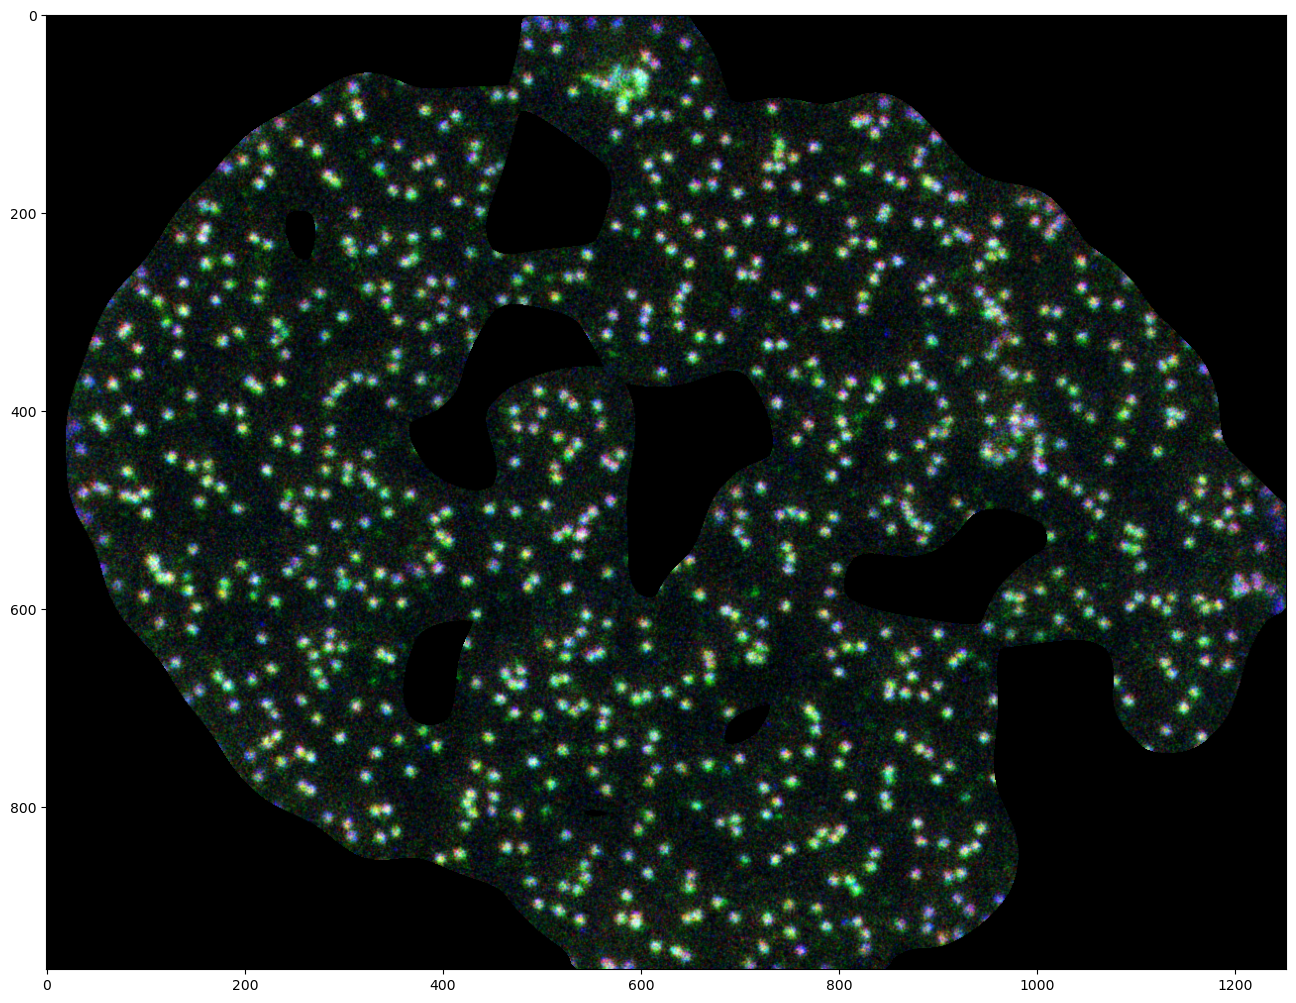

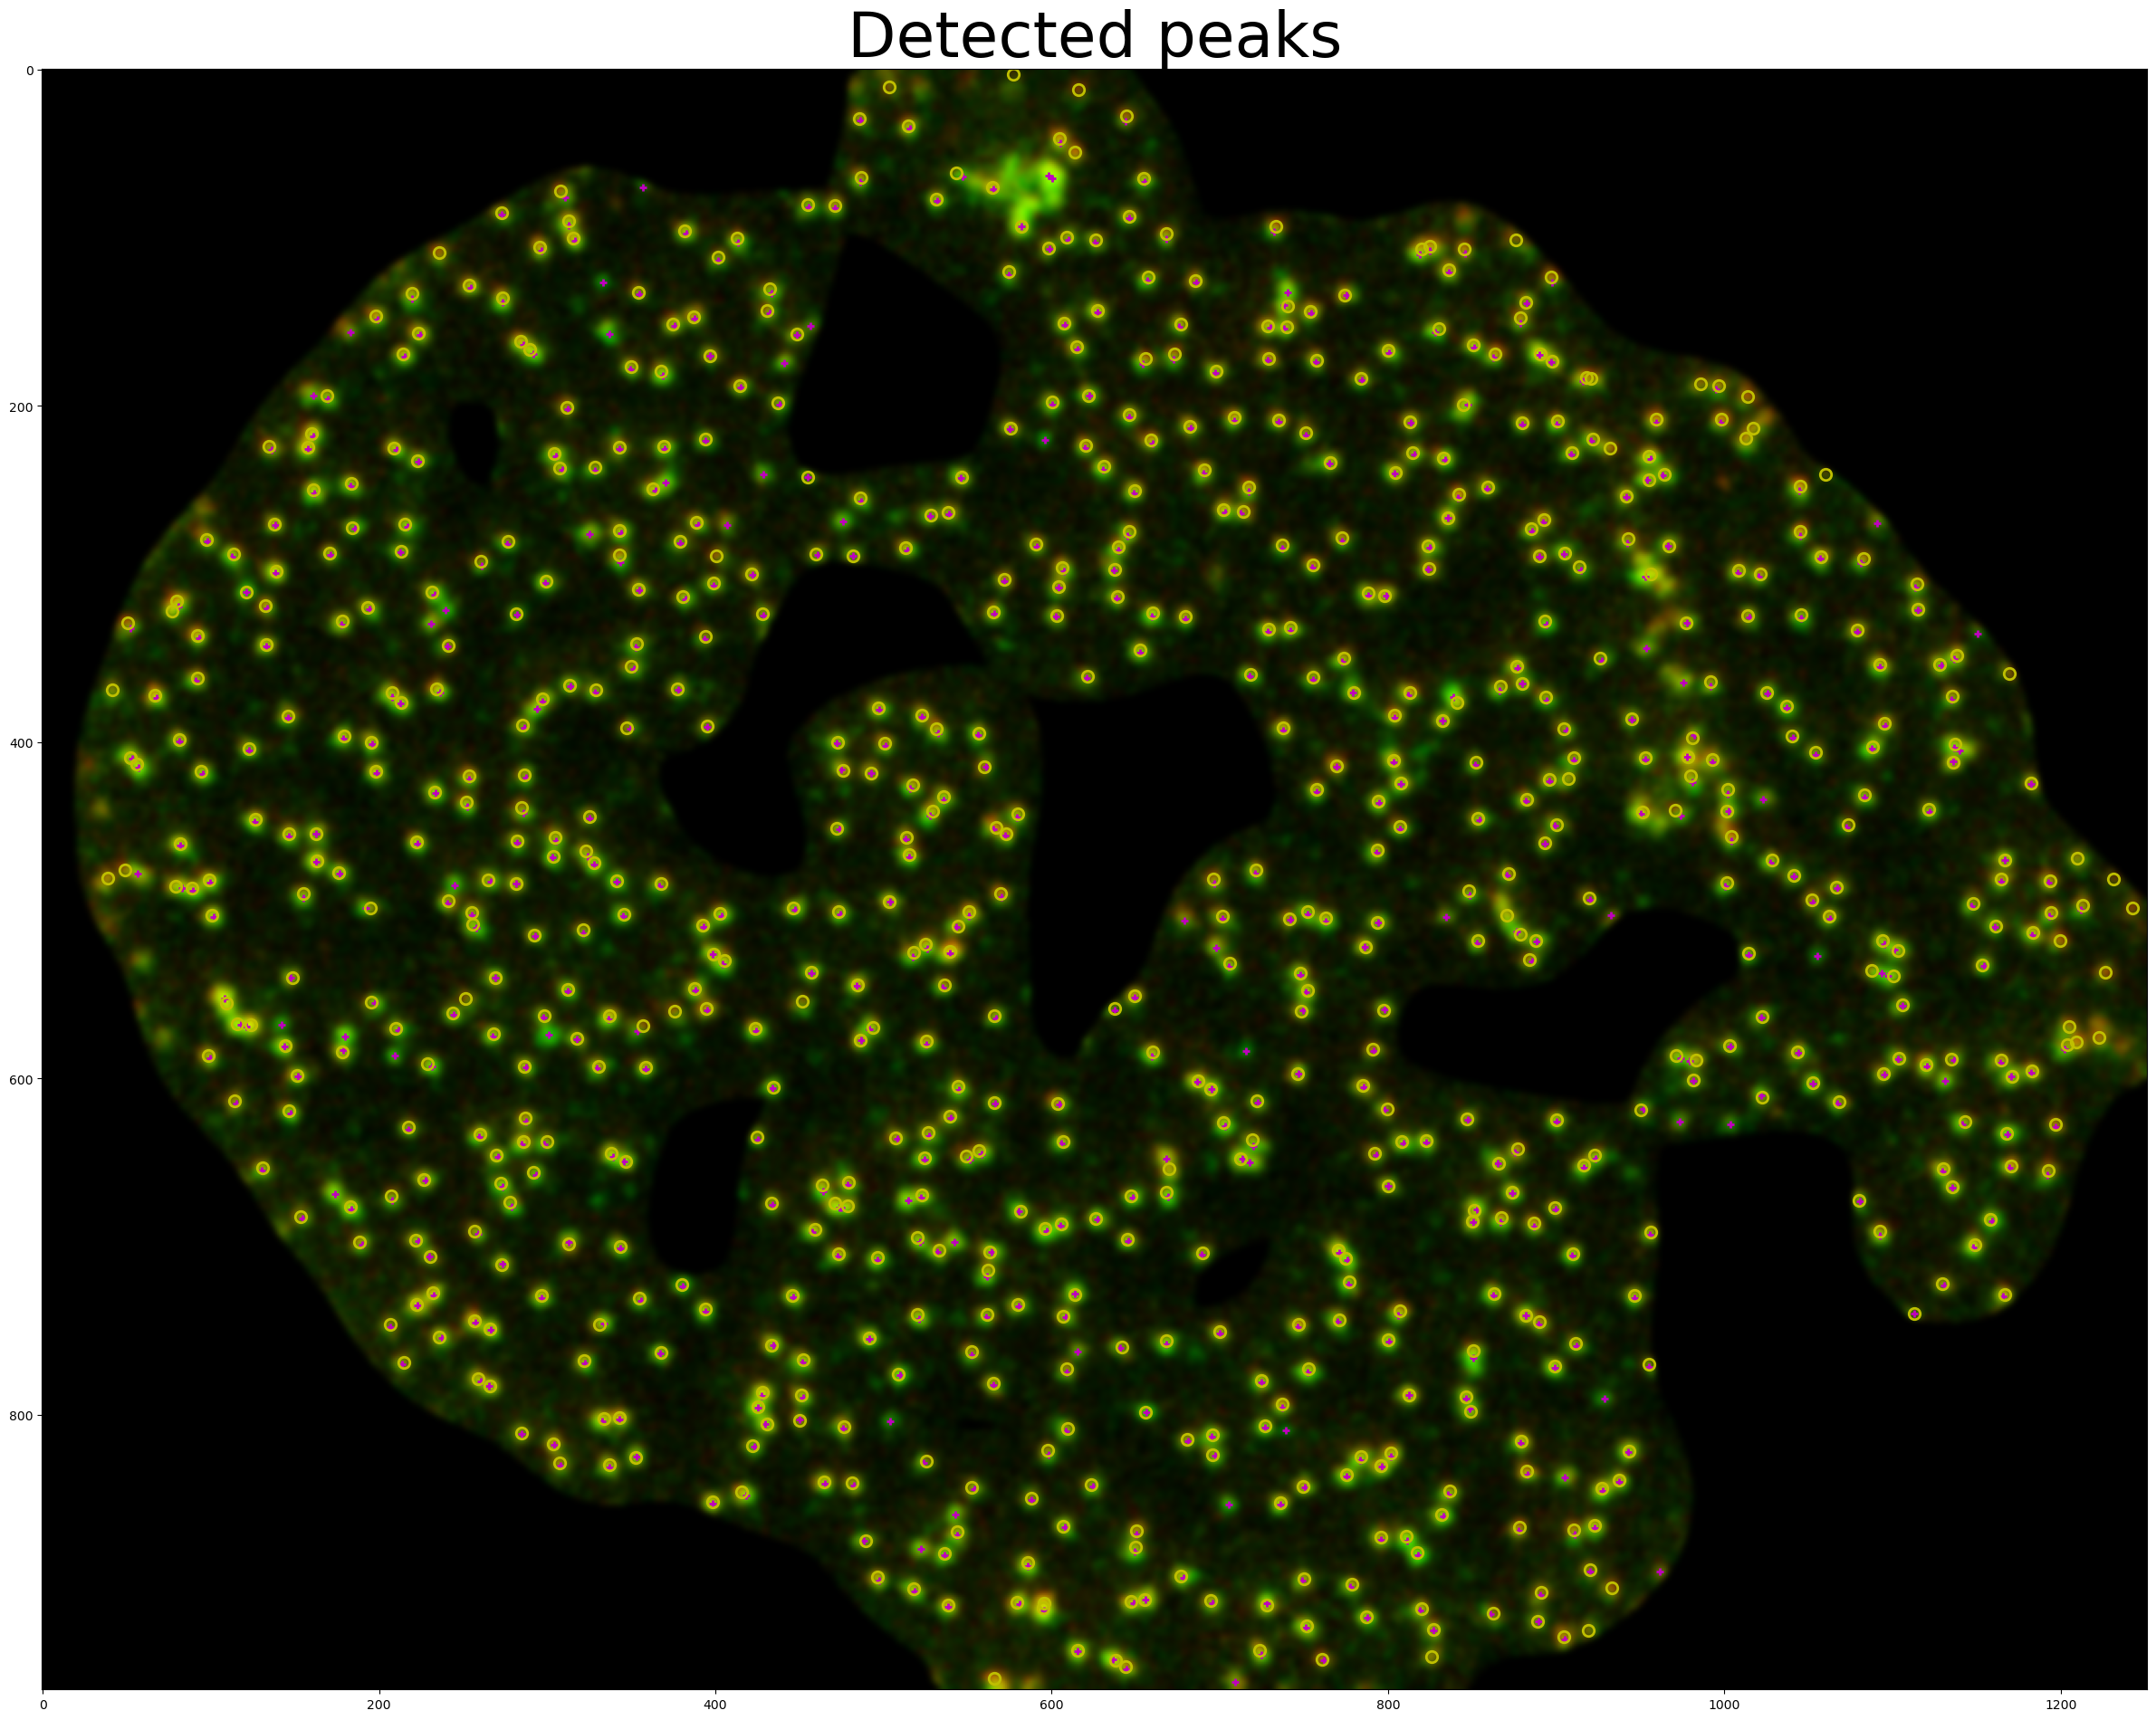

In [58]:
class Image:   
    image = None # RGB image

    imgname = None
    date = np.array([]) 
    NupX = np.array([]) # either the third labeled Nup or None  
    
    POMpeaks = np.array([])
    mABpeaks = np.array([])
    
    pore_coord = np.array([])
    mAB_POM_dist = []
    pore_status = []
    
    def __init__(self, imgname, date, NupX): # init defines what we know in advance before computing the maturity analysis 
        self.imgname = launch[4] 
        self.date = imgname.split('_')[0]
        self.NupX = launch[3]

    def preprocess (self, mABraw, POMraw, NupXraw): #mABraw, POMraw and NupXraw are defined out of the class definition
        mAB_img = process(mABraw, gf_nm, pxs_nm)
        POM_img = process(POMraw, gf_nm, pxs_nm)
        NupX_img = process(NupXraw, gf_nm, pxs_nm) #we call the function process defined in a file function
        RGB0 = np.dstack((mAB_img,POM_img,NupX_img))
        mask = nucleus_focus_mask(POM_img, gaussstd_nm=500, pxs_nm=15, num_di=12, num_er=5) # get binary mask 
        POMimg = (POM_img)*mask
        mABimg = (mAB_img)*mask
        NupXimg = (NupX_img)*mask
        RGB1 = np.dstack((mABimg,POMimg,NupXimg))
        #fig,ax0 = plt.subplots(figsize=(16,16))
        #ax0.imshow(RGB0)
        fig,ax1 = plt.subplots(figsize=(16,16))
        #ax1.imshow(RGB1)
        
        self.image = ax1.imshow(RGB1) 
        
        return(mABimg, POMimg, self.image) 
    
    def peaks(self, mABimg, POMimg):
        ## Determine thresholds with otsu method
        ThPOM = threshold_otsu(POMimg)+np.std(POMimg)  
        ThmAB = threshold_otsu(mABimg)#+0.5*np.std(mABimg)

        ## Apply Gaussian filter to POM and mAB images
        POMfilt = ndimage.gaussian_filter(POMimg,sm_size_nm/pxs_nm)
        mABfilt = ndimage.gaussian_filter(mABimg,sm_size_nm/pxs_nm)

        RGB2 = np.dstack((mABfilt,POMfilt,B))
        #fig, ax2 = plt.subplots(figsize=(30,30))
        #ax2.set_title('Blurred image for peak detetection', fontsize=50)
        #plt.imshow(RGB2)

        ## Detect POM and mAB peaks
        self.POMpeaks = detect_pores(POMfilt, threshold=ThPOM, fwhm=120/pxs_nm)
        self.mABpeaks = detect_pores(mABfilt, ThmAB, fwhm=90/pxs_nm) #detect_pore is a predifined function 
        #print(POMpeaks[1])

        fig, ax3 = plt.subplots(figsize=(30,30))
        plt.imshow(RGB2)
        POM_x_coord = self.POMpeaks[:,1]
        POM_y_coord = self.POMpeaks[:,0]
        mAB_x_coord = self.mABpeaks[:,1]
        mAB_y_coord = self.mABpeaks[:,0]
        
        ax3.scatter(POM_y_coord, POM_x_coord, s=30,c='m', marker='+',linewidths=2)
        ax3.scatter(mAB_y_coord, mAB_x_coord, s=80,c='#FF000000',marker='o',edgecolors='y',linewidths=2)
        ax3.set_title('Detected peaks', fontsize=50)
        
        return (ax3)
    
    def status(self, POMpeaks, mABpeaks):
        ## PIs: they should be at least 'min_peak_dist' away from mAB peak
        pore_coord = np.array([])
        mAB_POM_dist = []
        pore_status = []
        
        dist = min_peak_dist/pxs_nm
        for i in range (0,len(self.mABpeaks)): # Pas sûre de moi --> est ce que ça ne va pas tourner plus de fois que ce qu'il faut ? 
            if shorter_dist(self.POMpeaks[[i]],self.mABpeaks)>=dist:
                self.mAB_POM_dist.append(shorter_dist(self.POMpeaks[[i]],self.mABpeaks)*pxs_nm)
                pore_coord = np.append(pore_coord,np.array(self.POMpeaks[[i]])) # On récupère les coordonnées POM121 de chaque pore immature --> récupérer séparemment x et y  
                self.pore_coord = np.reshape(pore_coord,(-1,2))
                self.pore_status.append('PI')
            else:
                self.pore_status.append('NPC')
                pore_coord = np.append(pore_coord,np.array(self.mABpeaks[[i]]))
                self.pore_coord = np.reshape(pore_coord,(-1,2))
        return(self.pore_coord,self.mAB_POM_dist,self.pore_status)


image1 = Image(imgname=imgname,date=imgname.split('_')[0],NupX=launch[3])
image1_preprocess = image1.preprocess(mABraw, POMraw, NupXraw)
#print(image1_preprocess)
image1_peaks = image1.peaks(image1_preprocess[0],image1_preprocess[1])
#print(image1_peaks)
image1_status = image1.status(image1.POMpeaks,image1.mABpeaks)
#print(image1_status)

In [59]:
# Save an array for each pore 
pore_nb = len(image1.pore_status)
#Define csv file parameters where data are stored
header = ['Image_name', 'Pore_status','x_coordinate','y_coordinate']
# If 'w' mode = write (previous data are not stored), if 'a' mode = append (previous data are stored)
with open('pores.csv', 'a', newline='') as f: 
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    #write the data
    for i in range(1,pore_nb): # pour i allant de 0 au nb total de pore
        pore_data = (image1.imgname, image1.pore_status[i], image1.pore_coord[i][0],image1.pore_coord[i][1])
        pore_array = np.array(pore_data, dtype=object)
        writer.writerow(pore_array)

At this step, needed characteristics of each pore are stored in an array. All the arrays are stored in a csv file. 

We defined a class called Image that contains all the parameters related to an image. Next step: define a class pore that contains parameters and methods to define the pores as objects. The class pore contains sub classes: pore intermediate and NPC (mature pore). The class and the subclasses have the same parameters, the same methods but some computations will be done differently depending on the sub class. 

---

## Perform analysis on detected pores <a class="anchor" id="libraries"></a>

In [59]:
class Pore(): #Define parent class "pore": will have all the parameters and methods a pore has
    pore_coord = None 
    def __init__(self,pore_coord):
        # x_coordinates extracted from the results of the peaks function defined in the Image class 
        # y_coordinates (both x and y coordinates for mAB and POM)
        for i in range(0,image1_status[3]):
            
            
    #def diameter_measure():
        #pass

SyntaxError: incomplete input (153143276.py, line 8)

In [ ]:
class Pore_intermediate(Pore):
    
    def __init():
        pass
    
    def diameter_measure():
        #define the diameter measure for the pore intermediate

class NPC(Pore):
    
    def __init__():
        pass
    
    def diameter_measure():
        #define the diameter measure for the NPC (mature pore)